In [1]:
import os
import glob
import json
import pandas as pd


def load_reviews(folder_path):
    rows = []
    # find all JSON files in the folder
    for file_path in glob.glob(os.path.join(folder_path, '*.json')):
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        paper_id = data.get('paper_id')
        assessor = data.get('assessor')
        metrics = data.get('metrics', {})
        
        # group metrics by reviewer name
        reviewer_metrics = {}
        for key, value in metrics.items():
            # only process keys that start with "review_"
            if not key.startswith('review_'):
                continue
            parts = key.split('_')
            reviewer = parts[1]                          # e.g. "Palwinder-Singh"
            metric_name = '_'.join(parts[2:])            # e.g. "Comprehensiveness"
            
            reviewer_metrics.setdefault(reviewer, {})
            reviewer_metrics[reviewer][metric_name] = value
        
        # turn each reviewer’s metrics into a row
        for reviewer, mdict in reviewer_metrics.items():
            row = {
                'paper_id': paper_id,
                'assessor': assessor,
                'reviewer': reviewer
            }
            row.update(mdict)
            rows.append(row)
    
    # build the final DataFrame
    df = pd.DataFrame(rows)
    return df

# Example usage:
folder = 'Human_Annotation_Data'
df_human = load_reviews(folder)

# show the first few rows
df_human = df_human[df_human['Overall_Quality'] > 10]
df_human

,paper_id,assessor,reviewer,Comprehensiveness,Usage_of_Technical_Terms,Factuality,Sentiment_Polarity,Politeness,Vagueness,Objectivity,Fairness,Actionability,Constructiveness,Relevance_Alignment,Clarity_and_Readability,Overall_Quality
0,166,Sajad-Ebrahimi,Reviewer-7mFW,2,4,factual,neutral,polite,high,4,4,4,3,4,4,67
1,166,Sajad-Ebrahimi,Reviewer-FAWm,4,4,factual,neutral,polite,none,4,4,5,5,5,4,86
2,166,Sajad-Ebrahimi,Reviewer-kjkr,3,4,factual,neutral,polite,low,4,4,5,5,4,5,75
3,100,Seyed,Enrico-Daga,3,2,factual,positive,polite,none,4,5,4,4,4,4,80
4,100,Seyed,Julia-Bosque,5,4,factual,positive,polite,low,4,4,4,4,5,4,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,75,Ali-Ghorbanpour,Reviewer-s437,3,3,partially factual,neutral,polite,low,2,3,2,3,3,3,55
484,75,Ali-Ghorbanpour,Reviewer-mMGf,4,4,factual,negative,polite,none,4,4,4,5,4,4,80
485,75,Ali-Ghorbanpour,Reviewer-AtQ2,5,4,factual,positive,polite,none,4,4,3,4,4,5,90
486,75,Ali-Ghorbanpour,Reviewer-v6cq,2,3,partially factual,positive,polite,moderate,3,3,2,3,3,3,50


In [2]:
df_llama = pd.read_json('final_data/HA_ALL_llama.json', orient='records', lines=True)
df_qwen = pd.read_json('final_data/HA_ALL_qwen.json')
df_gpt = pd.read_csv('final_data/HA_ALL_gpt.csv')

In [3]:
# TODO: later, to compare qmetrics aggreement with llm and human.
df_qmetric = pd.read_json('final_data/HA_ALL_nonllm.json', orient='records', lines=True)
df_qmetric

,paper_id,title,abstract,review_text,authors,reviewer,review_date,review_rating,review_confidence,review_soundness,...,llm_citation_usage,llm_sentiment_polarity,llm_politeness,llm_hedging,llm_specificity,llm_domain_terms,llm_relevance_alignment,llm_readability,llm_overall_quality,llm_overall_score_100
0,123,Navigating Text-To-Image Customization: From L...,Text-to-image generative models have garnered ...,**Summary:** \nThis paper presents an open-sou...,"['~SHIH-YING_YEH1', '~Yu-Guan_Hsieh1', '~Zhido...",Reviewer_EGJf,1701662567826,6.0,3.0,3.0,...,None,None,None,None,None,NaN,NaN,NaN,NaN,None
1,123,Navigating Text-To-Image Customization: From L...,Text-to-image generative models have garnered ...,This paper proposes a comprehensive library fo...,"['~SHIH-YING_YEH1', '~Yu-Guan_Hsieh1', '~Zhido...",Reviewer_DWom,1699636125239,6.0,3.0,3.0,...,None,None,None,None,None,NaN,NaN,NaN,NaN,None
2,123,Navigating Text-To-Image Customization: From L...,Text-to-image generative models have garnered ...,"This author introduces LyCORIS, an open source...","['~SHIH-YING_YEH1', '~Yu-Guan_Hsieh1', '~Zhido...",Reviewer_PnHf,1699636125143,6.0,4.0,4.0,...,None,None,None,None,None,NaN,NaN,NaN,NaN,None
3,123,Navigating Text-To-Image Customization: From L...,Text-to-image generative models have garnered ...,"The authors propose LyCORIS, an open-source li...","['~SHIH-YING_YEH1', '~Yu-Guan_Hsieh1', '~Zhido...",Reviewer_ekPo,1699636125075,8.0,4.0,3.0,...,None,None,None,None,None,NaN,NaN,NaN,NaN,None
4,0,$\nu$-ensembles: Improving deep ensemble calib...,We present a method to improve the calibration...,"This paper introduces ν-ensembles, a novel dee...","['~Konstantinos_Pitas1', '~Julyan_Arbel1']",Reviewer_HFRa,1699636992453,3.0,4.0,2.0,...,None,None,None,None,None,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,118,Module Extraction for Efficient Object Query o...,The extraction of logically-independent fragme...,The submission addresses the problem of partit...,None,Anonymous,03/May/2014,NaN,NaN,NaN,...,False,negative,impolite,Heavy,5,2.0,1.0,3.0,40.0,20
657,61,EARTh: an Environmental Application Reference ...,The paper aims at providing a description of E...,This revision addresses my concerns. I am part...,None,Natasha Noy,22/Jul/2013,NaN,NaN,NaN,...,True,neutral,neutral,Minimal,somewhat specific,4.0,3.0,5.0,85.0,85
658,76,Facilitating Data Discovery by Connecting Rela...,"In this study, we investigate two approaches t...",The paper presents and compares RDF/XML (in th...,None,Anonymous,15/Jun/2013,NaN,NaN,NaN,...,no,neutral,neutral,Moderate,somewhat specific,2.0,4.0,3.0,64.0,72
659,76,Facilitating Data Discovery by Connecting Rela...,"In this study, we investigate two approaches t...",This paper investigates two different approach...,None,Ghislain Hachey,17/Jun/2013,NaN,NaN,NaN,...,yes,neutral,neutral,Minimal,somewhat specific,3.0,4.0,5.0,68.0,74


In [4]:
# remove 'llm_' from all columns prefix in df_llama and df_qwen
df_human.columns = df_human.columns.str.replace(' ', '_', regex=False)
df_llama.columns = df_llama.columns.str.replace(' ', '_', regex=False)
df_qwen.columns = df_qwen.columns.str.replace(' ', '_', regex=False)
df_gpt.columns = df_gpt.columns.str.replace(' ', '_', regex=False)

df_human.columns = df_human.columns.str.replace('llm_', '', regex=False)
df_llama.columns = df_llama.columns.str.replace('llm_', '', regex=False)
df_qwen.columns = df_qwen.columns.str.replace('llm_', '', regex=False)
df_gpt.columns = df_gpt.columns.str.replace('llm_', '', regex=False)

In [5]:
# print shared columns between df_llama and df
shared_columns_llama = set(df_llama.columns) & set(df_human.columns)
print("Shared columns between df_llama and df:")
print(shared_columns_llama)
# print shared columns between df_qwen and df
shared_columns_qwen = set(df_qwen.columns) & set(df_human.columns)
print("Shared columns between df_qwen and df:")
print(shared_columns_qwen)
# print shared columns between df_gpt and df
shared_columns_gpt = set(df_gpt.columns) & set(df_human.columns)
print("Shared columns between df_gpt and df:")
print(shared_columns_gpt)

Shared columns between df_llama and df:
{'Constructiveness', 'reviewer', 'Overall_Quality', 'Actionability', 'Usage_of_Technical_Terms', 'Sentiment_Polarity', 'Comprehensiveness', 'Politeness', 'Fairness', 'Clarity_and_Readability', 'paper_id', 'Relevance_Alignment', 'Objectivity', 'Vagueness', 'Factuality'}
Shared columns between df_qwen and df:
{'Constructiveness', 'reviewer', 'Overall_Quality', 'Actionability', 'Usage_of_Technical_Terms', 'Sentiment_Polarity', 'Comprehensiveness', 'Politeness', 'Fairness', 'Clarity_and_Readability', 'paper_id', 'Relevance_Alignment', 'Objectivity', 'Vagueness', 'Factuality'}
Shared columns between df_gpt and df:
{'Constructiveness', 'reviewer', 'Overall_Quality', 'Actionability', 'Usage_of_Technical_Terms', 'Sentiment_Polarity', 'Comprehensiveness', 'Politeness', 'Fairness', 'Clarity_and_Readability', 'paper_id', 'Relevance_Alignment', 'Objectivity', 'Vagueness', 'Factuality'}


In [6]:
# Convert paper_id and reviewer to string in all DataFrames
for dframe in [df_human, df_qwen, df_llama]:
    dframe['paper_id'] = dframe['paper_id'].astype(str)
    dframe['reviewer'] = dframe['reviewer'].astype(str)

# Define shared metrics (excluding paper_id and reviewer)
shared_metrics = [
    'Comprehensiveness', 'Usage_of_Technical_Terms', 'Relevance_Alignment',
    'Objectivity', 'Sentiment_Polarity', 'Vagueness', 'Factuality',
    'Fairness', 'Actionability', 'Overall_Quality', 'Constructiveness',
    'Clarity_and_Readability', 'Politeness'
]

# Rename columns with prefixes
df_human_renamed = df_human.rename(columns={col: f'Human_{col}' for col in shared_metrics})
df_qwen_renamed = df_qwen.rename(columns={col: f'Qwen_{col}' for col in shared_metrics})
df_llama_renamed = df_llama.rename(columns={col: f'Llama_{col}' for col in shared_metrics})
df_gpt_renamed = df_gpt.rename(columns={col: f'GPT_{col}' for col in shared_metrics})

# just for column reviewer, replace '_' and ' ' with '-'
df_llama_renamed['reviewer'] = df_llama_renamed['reviewer'].str.replace('_', '-', regex=False)
df_llama_renamed['reviewer'] = df_llama_renamed['reviewer'].str.replace(' ', '-', regex=False)
df_qwen_renamed['reviewer'] = df_qwen_renamed['reviewer'].str.replace('_', '-', regex=False)
df_qwen_renamed['reviewer'] = df_qwen_renamed['reviewer'].str.replace(' ', '-', regex=False)
df_human_renamed['reviewer'] = df_human_renamed['reviewer'].str.replace('_', '-', regex=False)
df_human_renamed['reviewer'] = df_human_renamed['reviewer'].str.replace(' ', '-', regex=False)
df_gpt_renamed['reviewer'] = df_gpt_renamed['reviewer'].str.replace('_', '-', regex=False)
df_gpt_renamed['reviewer'] = df_gpt_renamed['reviewer'].str.replace(' ', '-', regex=False)

# transform paper_id column in all dfs to int
df_human_renamed['paper_id'] = df_human_renamed['paper_id'].astype(int)
df_qwen_renamed['paper_id'] = df_qwen_renamed['paper_id'].astype(int)
df_llama_renamed['paper_id'] = df_llama_renamed['paper_id'].astype(int)
df_gpt_renamed['paper_id'] = df_gpt_renamed['paper_id'].astype(int)

# transform paper_id column in all dfs to int
df_human_renamed['reviewer'] = df_human_renamed['reviewer'].astype(str)
df_qwen_renamed['reviewer'] = df_qwen_renamed['reviewer'].astype(str)
df_llama_renamed['reviewer'] = df_llama_renamed['reviewer'].astype(str)
df_gpt_renamed['reviewer'] = df_gpt_renamed['reviewer'].astype(str)

# Merge Qwen and Llama first, then merge with Human
df_human_vs_llm = (
    df_human_renamed
    .merge(df_llama_renamed, on=['paper_id', 'reviewer'], how='inner')
    .merge(df_qwen_renamed, on=['paper_id', 'reviewer'], how='inner')
    .merge(df_gpt_renamed, on=['paper_id', 'reviewer'], how='inner')
)


# Create ordered column list (Human first, then Qwen, then Llama)
column_order = (
    ['paper_id', 'reviewer'] + 
    sorted([col for col in df_human_vs_llm if col.startswith('Human_')]) +
    sorted([col for col in df_human_vs_llm if col.startswith('Qwen_')]) +
    sorted([col for col in df_human_vs_llm if col.startswith('Llama_')]) +
    sorted([col for col in df_human_vs_llm if col.startswith('GPT_')])
)

df_human_vs_llm = df_human_vs_llm[column_order]
df_human_vs_llm

,paper_id,reviewer,Human_Actionability,Human_Clarity_and_Readability,Human_Comprehensiveness,Human_Constructiveness,Human_Factuality,Human_Fairness,Human_Objectivity,Human_Overall_Quality,...,GPT_Constructiveness,GPT_Factuality,GPT_Fairness,GPT_Objectivity,GPT_Overall_Quality,GPT_Politeness,GPT_Relevance_Alignment,GPT_Sentiment_Polarity,GPT_Usage_of_Technical_Terms,GPT_Vagueness
0,166,Reviewer-7mFW,4,4,2,3,factual,4,4,67,...,3,partially factual,3,3,60,neutral,4,neutral,4,moderate
1,166,Reviewer-FAWm,5,4,4,5,factual,4,4,86,...,4,factual,4,4,80,polite,5,neutral,4,low
2,166,Reviewer-kjkr,5,5,3,5,factual,4,4,75,...,3,factual,4,4,75,polite,5,neutral,5,low
3,100,Enrico-Daga,4,4,3,4,factual,5,4,80,...,4,factual,5,4,85,polite,5,positive,4,low
4,100,Julia-Bosque,4,4,5,4,factual,4,4,87,...,5,factual,5,5,5,polite,5,positive,5,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,75,Reviewer-s437,2,3,3,3,partially factual,3,2,55,...,3,factual,4,4,85,polite,5,positive,5,low
753,75,Reviewer-mMGf,4,4,4,5,factual,4,4,80,...,3,factual,4,4,75,polite,5,neutral,4,low
754,75,Reviewer-AtQ2,3,5,5,4,factual,4,4,90,...,4,factual,5,5,90,polite,5,neutral,5,none
755,75,Reviewer-v6cq,2,3,2,3,partially factual,3,3,50,...,3,factual,4,3,65,polite,4,positive,3,moderate


In [7]:
# how many unique pair of reviewer and paper_id are there
unique_pairs = df_human_vs_llm[['paper_id', 'reviewer']].drop_duplicates()
print(f"Unique pairs of reviewer and paper_id: {len(unique_pairs)}")


Unique pairs of reviewer and paper_id: 406


In [8]:
df_human_vs_llm = df_human_vs_llm.dropna()
df_human_vs_llm

,paper_id,reviewer,Human_Actionability,Human_Clarity_and_Readability,Human_Comprehensiveness,Human_Constructiveness,Human_Factuality,Human_Fairness,Human_Objectivity,Human_Overall_Quality,...,GPT_Constructiveness,GPT_Factuality,GPT_Fairness,GPT_Objectivity,GPT_Overall_Quality,GPT_Politeness,GPT_Relevance_Alignment,GPT_Sentiment_Polarity,GPT_Usage_of_Technical_Terms,GPT_Vagueness
0,166,Reviewer-7mFW,4,4,2,3,factual,4,4,67,...,3,partially factual,3,3,60,neutral,4,neutral,4,moderate
1,166,Reviewer-FAWm,5,4,4,5,factual,4,4,86,...,4,factual,4,4,80,polite,5,neutral,4,low
2,166,Reviewer-kjkr,5,5,3,5,factual,4,4,75,...,3,factual,4,4,75,polite,5,neutral,5,low
3,100,Enrico-Daga,4,4,3,4,factual,5,4,80,...,4,factual,5,4,85,polite,5,positive,4,low
4,100,Julia-Bosque,4,4,5,4,factual,4,4,87,...,5,factual,5,5,5,polite,5,positive,5,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,75,Reviewer-wEMM,3,4,3,4,factual,3,3,70,...,3,factual,4,4,75,polite,5,neutral,4,low
752,75,Reviewer-s437,2,3,3,3,partially factual,3,2,55,...,3,factual,4,4,85,polite,5,positive,5,low
753,75,Reviewer-mMGf,4,4,4,5,factual,4,4,80,...,3,factual,4,4,75,polite,5,neutral,4,low
755,75,Reviewer-v6cq,2,3,2,3,partially factual,3,3,50,...,3,factual,4,3,65,polite,4,positive,3,moderate


In [9]:
print("Unique values per column:")
for col in df_human_vs_llm.columns:
    if col not in ['paper_id', 'reviewer']:
        unique_vals = df_human_vs_llm[col].unique()
        try:
            # Try numerical sorting
            sorted_vals = sorted(unique_vals)
        except TypeError:
            # Fallback to string sorting for mixed types
            sorted_vals = sorted(unique_vals, key=lambda x: str(x))
        
        print(f"\n{col} ({len(sorted_vals)} unique values):")
        print(*sorted_vals[:10], sep=', ')  # Show first 10 values
        if len(sorted_vals) > 10:
            print(f"... plus {len(sorted_vals)-10} more values")

Unique values per column:

Human_Actionability (6 unique values):
0, 1, 2, 3, 4, 5

Human_Clarity_and_Readability (6 unique values):
0, 1, 2, 3, 4, 5

Human_Comprehensiveness (6 unique values):
0, 1, 2, 3, 4, 5

Human_Constructiveness (6 unique values):
0, 1, 2, 3, 4, 5

Human_Factuality (3 unique values):
factual, partially factual, unfactual

Human_Fairness (5 unique values):
1, 2, 3, 4, 5

Human_Objectivity (6 unique values):
0, 1, 2, 3, 4, 5

Human_Overall_Quality (49 unique values):
12, 19, 20, 25, 29, 30, 33, 35, 37, 38
... plus 39 more values

Human_Politeness (3 unique values):
impolite, neutral, polite

Human_Relevance_Alignment (5 unique values):
1, 2, 3, 4, 5

Human_Sentiment_Polarity (3 unique values):
negative, neutral, positive

Human_Usage_of_Technical_Terms (6 unique values):
0, 1, 2, 3, 4, 5

Human_Vagueness (5 unique values):
extreme, high, low, moderate, none

Qwen_Actionability (6 unique values):
0, 1, 2, 3, 4, 5

Qwen_Clarity_and_Readability (5 unique values):
0, 1

In [10]:
df_human_vs_llm.columns

Index(['paper_id', 'reviewer', 'Human_Actionability',
       'Human_Clarity_and_Readability', 'Human_Comprehensiveness',
       'Human_Constructiveness', 'Human_Factuality', 'Human_Fairness',
       'Human_Objectivity', 'Human_Overall_Quality', 'Human_Politeness',
       'Human_Relevance_Alignment', 'Human_Sentiment_Polarity',
       'Human_Usage_of_Technical_Terms', 'Human_Vagueness',
       'Qwen_Actionability', 'Qwen_Clarity_and_Readability',
       'Qwen_Comprehensiveness', 'Qwen_Constructiveness', 'Qwen_Factuality',
       'Qwen_Fairness', 'Qwen_Objectivity', 'Qwen_Overall_Quality',
       'Qwen_Politeness', 'Qwen_Relevance_Alignment',
       'Qwen_Sentiment_Polarity', 'Qwen_Usage_of_Technical_Terms',
       'Qwen_Vagueness', 'Llama_Actionability',
       'Llama_Clarity_and_Readability', 'Llama_Comprehensiveness',
       'Llama_Constructiveness', 'Llama_Factuality', 'Llama_Fairness',
       'Llama_Objectivity', 'Llama_Overall_Quality', 'Llama_Politeness',
       'Llama_Relevance_A

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
import krippendorff
from scipy.stats import pearsonr, kendalltau

# Assuming your DataFrame is named 'df'
df = df_human_vs_llm.copy()


CATEGORY_MAP = {
    'Factuality': ['factual', 'partially factual', 'unfactual'],
    'Politeness': ['polite', 'neutral', 'impolite'],
    'Sentiment_Polarity': ['negative', 'neutral', 'positive'],
    'Vagueness': ['none', 'low', 'moderate', 'high', 'extreme']
}

results = []

# Process categorical features
for feature in CATEGORY_MAP:
    human_col = f"Human_{feature}"
    for llm in ['Qwen', 'Llama', 'GPT']:
        llm_col = f"{llm}_{feature}"
        if human_col not in df.columns or llm_col not in df.columns:
            continue  # Skip if columns are missing
        
        temp_df = df[[human_col, llm_col]].copy()
        valid_labels = CATEGORY_MAP[feature]
        
        # Filter rows with valid labels
        mask = temp_df[human_col].isin(valid_labels) & temp_df[llm_col].isin(valid_labels)
        temp_df = temp_df[mask].reset_index(drop=True)
        
        if len(temp_df) < 2:
            continue  # Not enough data
        
        # Map labels to integers
        label_to_int = {label: idx for idx, label in enumerate(valid_labels)}
        temp_df[human_col] = temp_df[human_col].map(label_to_int)
        temp_df[llm_col] = temp_df[llm_col].map(label_to_int)
        
        # Compute metrics
        try:
            kappa = cohen_kappa_score(temp_df[human_col], temp_df[llm_col])
        except:
            kappa = np.nan
        
        data = [temp_df[human_col].values, temp_df[llm_col].values]
        try:
            alpha = krippendorff.alpha(data, level_of_measurement='ordinal')
        except:
            alpha = np.nan
        
        try:
            pearson_corr, _ = pearsonr(temp_df[human_col], temp_df[llm_col])
        except:
            pearson_corr = np.nan
        
        try:
            kendall_corr, _ = kendalltau(temp_df[human_col], temp_df[llm_col])
        except:
            kendall_corr = np.nan
        
        results.append({
            'Human_Column': human_col,
            'LLM_Column': llm_col,
            'Cohen_Kappa': kappa,
            'Krippendorff_Alpha': alpha,
            'Pearson': pearson_corr,
            'Kendall_Tau': kendall_corr
        })

# Process non-categorical features
all_features = set(col.split('_', 1)[1] for col in df.columns if col.startswith('Human_'))
non_categorical_features = [f for f in all_features if f not in CATEGORY_MAP]

for feature in non_categorical_features:
    human_col = f"Human_{feature}"
    for llm in ['Qwen', 'Llama', 'GPT']:
        llm_col = f"{llm}_{feature}"
        if human_col not in df.columns or llm_col not in df.columns:
            continue  # Skip if columns are missing
        
        temp_df = df[[human_col, llm_col]].dropna().copy()
        if len(temp_df) < 2:
            continue  # Not enough data
        
        # Ensure integer type
        try:
            temp_df[human_col] = temp_df[human_col].astype(int)
            temp_df[llm_col] = temp_df[llm_col].astype(int)
        except:
            continue  # Skip if conversion fails
        
        # Compute metrics
        try:
            kappa = cohen_kappa_score(temp_df[human_col], temp_df[llm_col])
        except:
            kappa = np.nan
        
        data = [temp_df[human_col].values, temp_df[llm_col].values]
        try:
            alpha = krippendorff.alpha(data, level_of_measurement='ordinal')
        except:
            alpha = np.nan
        
        try:
            pearson_corr, _ = pearsonr(temp_df[human_col], temp_df[llm_col])
        except:
            pearson_corr = np.nan
        
        try:
            kendall_corr, _ = kendalltau(temp_df[human_col], temp_df[llm_col])
        except:
            kendall_corr = np.nan
        
        results.append({
            'Human_Column': human_col,
            'LLM_Column': llm_col,
            'Cohen_Kappa': kappa,
            'Krippendorff_Alpha': alpha,
            'Pearson': pearson_corr,
            'Kendall_Tau': kendall_corr
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

,Human_Column,LLM_Column,Cohen_Kappa,Krippendorff_Alpha,Pearson,Kendall_Tau
0,Human_Factuality,Qwen_Factuality,0.059585,0.070765,0.076653,0.072435
1,Human_Factuality,Llama_Factuality,-0.007247,-0.043255,-0.058576,-0.039547
2,Human_Factuality,GPT_Factuality,0.104958,0.061621,0.184969,0.180236
3,Human_Politeness,Qwen_Politeness,0.083640,0.095348,0.137284,0.124001
4,Human_Politeness,Llama_Politeness,0.062778,0.028878,0.079306,0.086639
5,Human_Politeness,GPT_Politeness,0.100629,0.113243,0.132065,0.120152
6,Human_Sentiment_Polarity,Qwen_Sentiment_Polarity,0.188619,0.374629,0.393081,0.354456
7,Human_Sentiment_Polarity,Llama_Sentiment_Polarity,0.134221,0.261443,0.331700,0.302705
8,Human_Sentiment_Polarity,GPT_Sentiment_Polarity,0.180355,0.404097,0.433254,0.395046
9,Human_Vagueness,Qwen_Vagueness,0.101285,0.164682,0.150831,0.152141


In [12]:
results_df.to_csv('final_data/human_vs_llm_agreement_corr.csv', index=False)

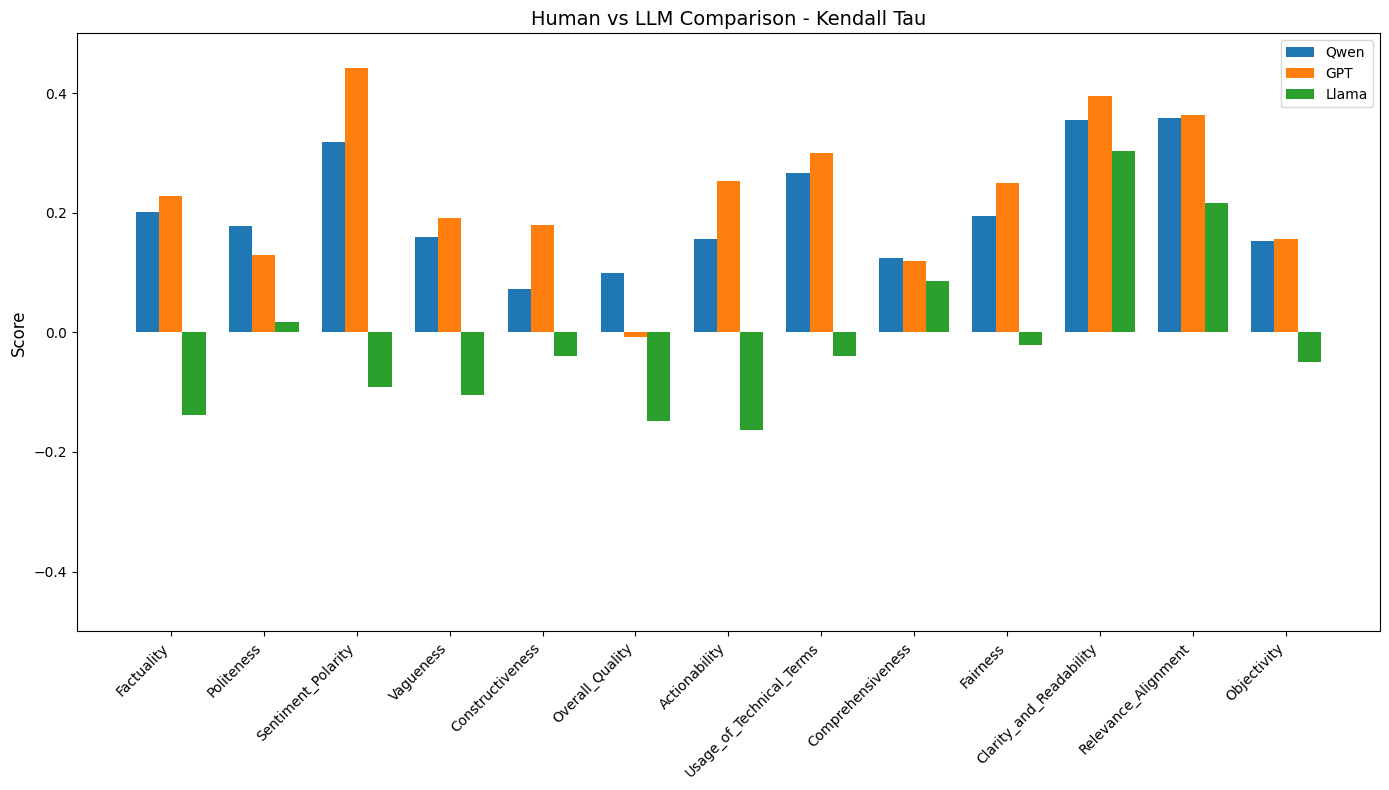

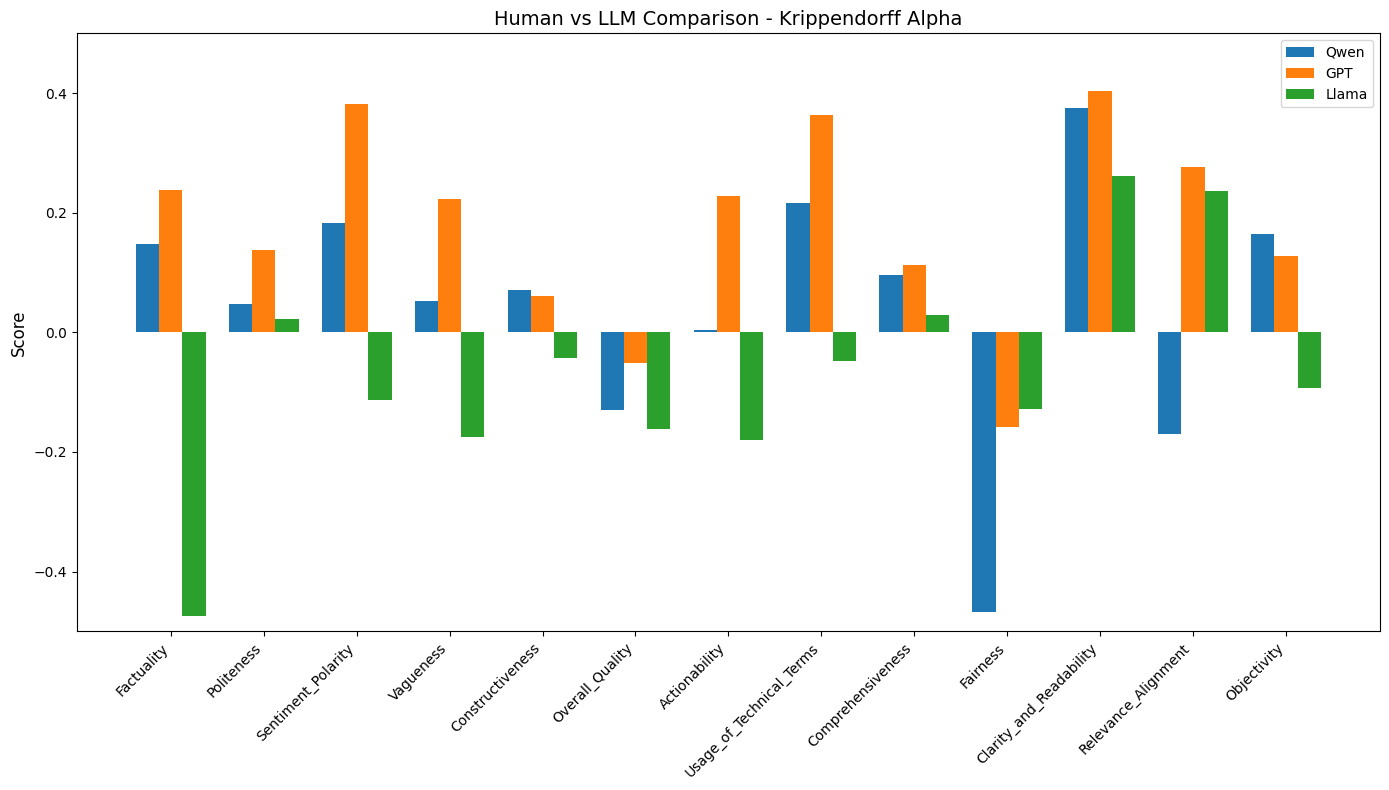

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data and preprocess
df = results_df.copy()

# Extract LLM names from LLM_Column
df['LLM'] = df['LLM_Column'].str.split('_').str[0]

# Replace negative values with 0 for our target metrics
df['Kendall_Tau'] = df['Kendall_Tau']  #.apply(lambda x: max(x, 0))
df['Krippendorff_Alpha'] = df['Krippendorff_Alpha']  #.apply(lambda x: max(x, 0))

# Get unique features and LLMs
features = df['Human_Column'].str.replace('Human_', '').unique()
llms = ['Qwen', 'GPT', 'Llama']
colors = {'Qwen': '#1f77b4', 'GPT': '#ff7f0e', 'Llama': '#2ca02c'}

# Create separate figures for each metric
for metric in ['Kendall_Tau', 'Krippendorff_Alpha']:
    plt.figure(figsize=(14, 8))
    
    # Set positions and width
    n_features = len(features)
    bar_width = 0.25
    x = np.arange(n_features)
    
    # Plot bars for each LLM
    for i, llm in enumerate(llms):
        # Get values for current LLM and metric
        values = df[df['LLM'] == llm].sort_values('Human_Column')[metric].values
        plt.bar(x + i*bar_width, values, bar_width, color=colors[llm], label=llm)
    
    # Add labels and formatting
    plt.title(f'Human vs LLM Comparison - {metric.replace("_", " ")}', fontsize=14)
    plt.xlabel('', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(x + bar_width, features, rotation=45, ha='right')
    plt.ylim(-0.5, 0.5)
    plt.legend(title='')
    
    plt.tight_layout()
    plt.show()

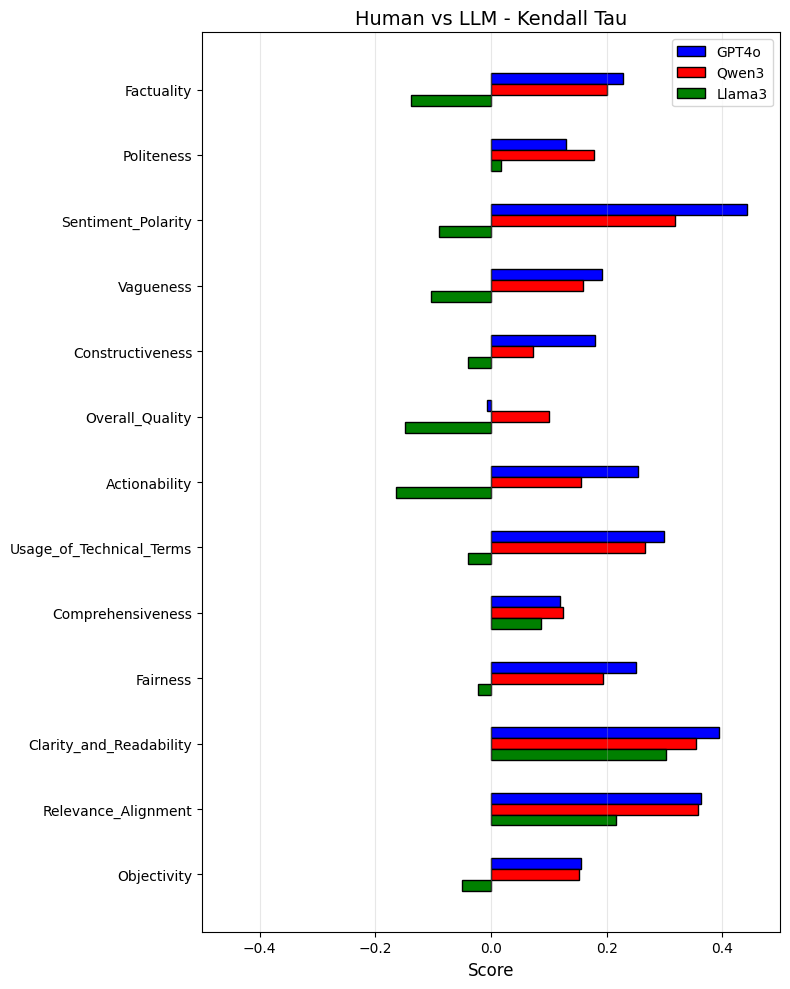

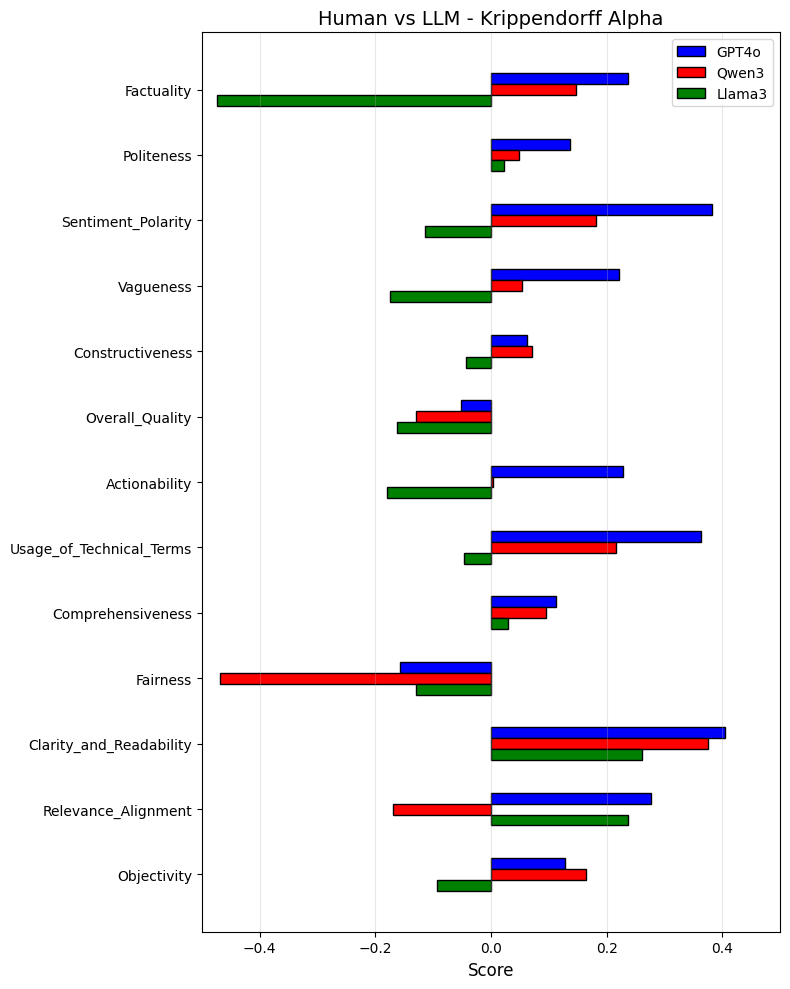

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data and preprocess
df = results_df.copy()

# Extract LLM names from LLM_Column
df['LLM'] = df['LLM_Column'].str.split('_').str[0]

# Replace negative values with 0 for target metrics
# df['Kendall_Tau'] = df['Kendall_Tau'].apply(lambda x: max(x, 0))
# df['Krippendorff_Alpha'] = df['Krippendorff_Alpha'].apply(lambda x: max(x, 0))

# Get unique features and LLMs
features = df['Human_Column'].str.replace('Human_', '').unique()
llms = ['GPT', 'Qwen', 'Llama']
colors = {'Qwen': 'red', 'GPT': 'blue', 'Llama': 'green'}

# Create separate figures for each metric
for metric in ['Kendall_Tau', 'Krippendorff_Alpha']:
    plt.figure(figsize=(8, 10))  # Adjusted for better vertical spacing
    
    # Set positions and dimensions
    n_features = len(features)
    bar_height = 0.25
    y = np.arange(n_features) * 1.5  # Vertical spacing between metric groups
    
    # Plot horizontal bars
    for i, llm in enumerate(llms):
        sorted_df = df[df['LLM'] == llm].sort_values('Human_Column')
        values = sorted_df[metric].values
        tmp_label = ''
        if llm == 'Qwen':
            tmp_label = 'Qwen3'
        elif llm == 'GPT':
            tmp_label = 'GPT4o'
        elif llm == 'Llama':
            tmp_label = 'Llama3'
        plt.barh(y + i*bar_height, 
                values, 
                height=bar_height,
                edgecolor='black',
                linewidth=1,
                color=colors[llm], 
                label=tmp_label)
    
    # Format axes and labels
    plt.title(f'Human vs LLM - {metric.replace("_", " ")}', fontsize=14)
    plt.xlabel('Score', fontsize=12)
    plt.ylabel('', fontsize=12)
    plt.yticks(y + bar_height, features, rotation=0, ha='right')
    plt.xlim(-0.5, 0.5)
    plt.gca().invert_yaxis()  # Top metric appears first
    plt.grid(axis='x', alpha=0.3)
    
    # Add legend and adjust layout
    plt.legend(loc='upper right', frameon=True)
    plt.tight_layout()
    plt.show()

In [21]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics import cohen_kappa_score, mean_absolute_error, mean_squared_error
# from scipy.stats import pearsonr, kendalltau  # Changed import
# import krippendorff


# df_human_vs_llm = pd.read_json('final_data/human_vs_llm.json')

# # Define valid categories for categorical metrics
# CATEGORY_MAP = {
#     'Factuality': ['factual', 'partially factual', 'unfactual'],
#     'Politeness': ['polite', 'neutral', 'impolite'],
#     'Sentiment_Polarity': ['negative', 'neutral', 'positive'],
#     'Vagueness': ['none', 'low', 'moderate', 'high', 'extreme']
# }

# # Define metric types
# numerical_metrics = [
#     'Actionability', 'Clarity_and_Readability', 'Comprehensiveness',
#     'Constructiveness', 'Fairness', 'Objectivity', 'Overall_Quality',
#     'Relevance_Alignment', 'Usage_of_Technical_Terms'
# ]

# categorical_metrics = list(CATEGORY_MAP.keys())

# def preprocess_data(df):
#     """Handle data type conversions and invalid values"""
#     # Process numerical metrics
#     for metric in numerical_metrics:
#         for prefix in ['Human', 'Qwen', 'Llama']:
#             col = f"{prefix}_{metric}"
#             # Convert to numeric, coerce errors to NaN
#             df[col] = pd.to_numeric(df[col], errors='coerce')
    
#     # Process categorical metrics
#     for metric in categorical_metrics:
#         valid_categories = CATEGORY_MAP[metric]
#         for prefix in ['Human', 'Qwen', 'Llama']:
#             col = f"{prefix}_{metric}"
#             # Convert to string and lowercase for consistency
#             df[col] = df[col].astype(str).str.lower().str.strip()
#             # Mark invalid values as NaN
#             df[col] = df[col].where(df[col].isin(valid_categories))
    
#     return df.dropna()

# # Preprocess the entire dataframe
# processed_df = preprocess_data(df_human_vs_llm.copy())

# results = []

# for metric in numerical_metrics + categorical_metrics:
#     for pair in [('Human', 'Qwen'), ('Human', 'Llama')]:  # , ('Qwen', 'Llama')
#         col1 = f"{pair[0]}_{metric}"
#         col2 = f"{pair[1]}_{metric}"
        
#         # Filter valid pairs specifically for this metric pair
#         valid_data = processed_df[[col1, col2]].dropna()
        
#         if len(valid_data) < 2:
#             continue
            
#         entry = {
#             'metric': metric,
#             'pair': f"{pair[0]}-{pair[1]}",
#             'n_samples': len(valid_data)
#         }
        
#         if metric in numerical_metrics:
#             # Ensure numerical types
#             valid_data = valid_data.apply(pd.to_numeric, errors='coerce').dropna()
            
#             entry.update({
#                 'pearson': pearsonr(valid_data[col1], valid_data[col2])[0],
#                 'kendall_tau': kendalltau(valid_data[col1], valid_data[col2])[0],  # Changed metric
#                 'MAE': mean_absolute_error(valid_data[col1], valid_data[col2]),
#                 'RMSE': np.sqrt(mean_squared_error(valid_data[col1], valid_data[col2]))
#             })
            
#             try:
#                 entry['krippendorff_alpha'] = krippendorff.alpha(
#                     reliability_data=[valid_data[col1].values, 
#                     valid_data[col2].values],
#                     level_of_measurement='interval'
#                 )
#             except:
#                 entry['krippendorff_alpha'] = np.nan
                
#         if metric in categorical_metrics:
#             # Additional check for categorical consistency
#             valid_data = valid_data[
#                 valid_data[col1].isin(CATEGORY_MAP[metric]) & 
#                 valid_data[col2].isin(CATEGORY_MAP[metric])
#             ]
            
#             if len(valid_data) < 2:
#                 continue
                
#             entry['n_samples'] = len(valid_data)
#             entry['cohen_kappa'] = cohen_kappa_score(
#                 valid_data[col1], 
#                 valid_data[col2]
#             )
            
#             try:
#                 entry['krippendorff_alpha'] = krippendorff.alpha(
#                     reliability_data=[valid_data[col1].values, 
#                     valid_data[col2].values],
#                     level_of_measurement='nominal'
#                 )
#             except:
#                 entry['krippendorff_alpha'] = np.nan
                
#         results.append(entry)

# agreement_df = pd.DataFrame(results)

# # Add significance indicators
# def add_significance(row):
#     if row['n_samples'] < 30:
#         return '*' * (3 - (row['n_samples'] // 10))
#     return ''

# agreement_df['sig'] = agreement_df.apply(add_significance, axis=1)

# column_order = [
#     'metric', 'pair', 'n_samples', 'sig',
#     'pearson', 'kendall_tau', 'MAE', 'RMSE',  # Changed column name
#     'cohen_kappa', 'krippendorff_alpha'
# ]
# agreement_df = agreement_df[column_order]

# # save agreement_df.sort_values(['metric', 'pair']) to csv
# agreement_df.sort_values(['metric', 'pair']).drop(['sig'], axis=1).to_csv('final_data/human_vs_llm.csv', index=False)

In [ ]:
# tmp = pd.read_csv('final_data/human_vs_llm.csv')
# # tmp